In [2]:
include("../channels.jl")
using PyPlot
using LaTeXStrings
using Profile
using JLD2, FileIO

In [6]:
function block_adam_op!(state, i, j, p, dilation)
    if rand() < dilation
        cl = random_clifford(2b)
        rg = cat((i-1)*b+1:i*b, (j-1)*b+1:j*b, dims=1)
        clifford_action!(cl, state, rg)
    end
    if rand() < p && rand() < dilation
        for k in 1:b
            depolarize!(state, (i-1)*b+k)
            depolarize!(state, (j-1)*b+k)
        end
    end
    return nothing
end

function block_bw_update!(state, p, dilation, periodic=true)
    n = div(size(state, 2), b)
    for ini in [1, 2]
        for i in ini : 2 : (periodic ? n : n-1)
            j = i==n ? 1 : i+1
            block_adam_op!(state, i, j, p, dilation)
        end
    end
    return nothing
end

block_bw_update! (generic function with 2 methods)

In [11]:
n = 64
p_list = 0.05:0.05:0.2
dilation = 0.01
n_average = 1000
n_step = 512
b = 8

ees = zeros(length(p_list), n_step)

for i in 1:length(p_list)
    p = p_list[i]
    for _ in 1:n_average
        state = all_up(n * b)
        for k in 1:n_step
            ees[i, k] += entropy(state)
            block_bw_update!(state, p, dilation)
        end
    end
end
ees ./= n_average
result = ees

@save "./cache/b_dp_slow.jld2" result

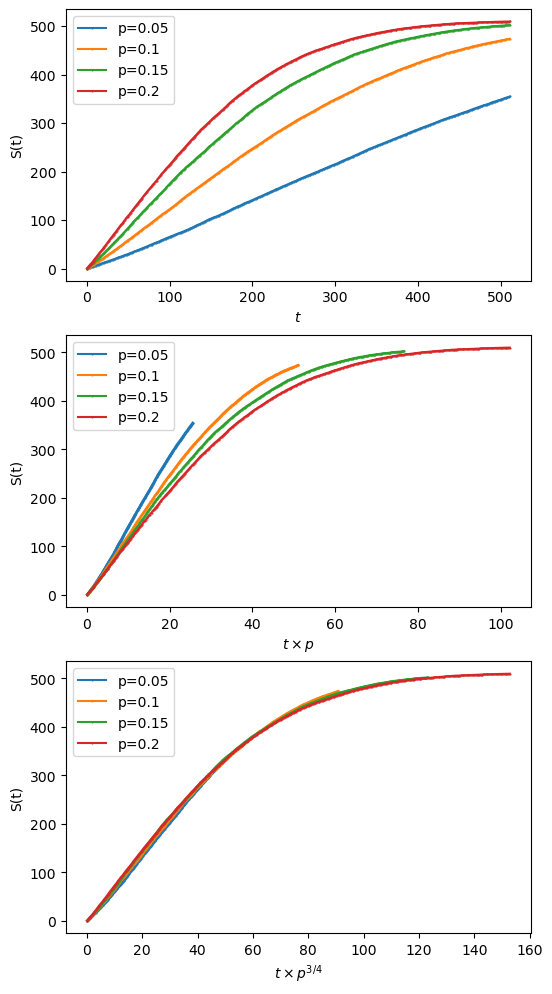

PyObject <matplotlib.legend.Legend object at 0x00000000014AF9A0>

In [13]:
@load "./cache/b_dp_slow.jld2" result

n = 64
p_list = 0.05:0.05:0.2
n_step = 512
ees = result
fg, ax = subplots(3, figsize=(6, 12))

for i in 1:length(p_list)
    x = (0:n_step-1)
    ax[1].plot(x, ees[i, :], ".-", label=string("p=", p_list[i]), ms=1)
    ax[2].plot(x .* p_list[i].^1, ees[i, :], ".-", label=string("p=", p_list[i]), ms=1)
    ax[3].plot(x .* p_list[i].^0.75, ees[i, :], ".-", label=string("p=", p_list[i]), ms=1)
end
ax[1].set_xlabel(L"t")
ax[1].set_ylabel("S(t)")
ax[1].legend()
ax[2].set_xlabel(L"t\times p")
ax[2].set_ylabel("S(t)")
ax[2].legend()
ax[3].set_xlabel(L"t\times p^{3/4}")
ax[3].set_ylabel("S(t)")
ax[3].legend()